# Insurance charges prediction [LGBM]

Giskard is an open-source framework for testing all ML models, from LLMs to tabular models. Don’t hesitate to give the project a [star on GitHub](https://github.com/Giskard-AI/giskard) ⭐️ if you find it useful!

In this notebook, you’ll learn how to create comprehensive test suites for your model in a few lines of code, thanks to Giskard’s open-source Python library.

Use-case:

* Regression to predict the insurance charges based on medical and social data.
* Model: `LGBMRegressor`
* [Dataset](https://www.kaggle.com/datasets/teertha/ushealthinsurancedataset)

Outline:  

* Detect vulnerabilities automatically with Giskard’s scan
* Automatically generate & curate a comprehensive test suite to test your model beyond accuracy-related metrics
* Upload your model to the Giskard Hub to:  

    * Debug failing tests & diagnose issues
    * Compare models & decide which one to promote
    * Share your results & collect feedback from non-technical team members

## Install dependencies
Make sure to install the `giskard`

In [ ]:
%pip install giskard --upgrade

We also install the project-specific dependencies for this tutorial.

In [ ]:
%pip install lightgbm

## Troubleshooting

If you encounter a segmentation fault on macOS at any point during this tutorial, check: https://docs.giskard.ai/en/latest/contribute/dev-environment.html

## Import libraries

In [1]:
import warnings
from pathlib import Path
from urllib.request import urlretrieve

import pandas as pd
from absl import logging
from lightgbm import LGBMRegressor
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from giskard import GiskardClient, testing, Dataset, Model, scan, Suite

## Notebook-level settings

In [2]:
logging.set_verbosity(logging.ERROR)
warnings.filterwarnings("ignore", message=r"Passing", category=FutureWarning)

## Define constants

In [3]:
# Constants.
NUMERICAL_COLS = ["bmi", "age", "children"]
CATEGORICAL_COLS = ["sex", "smoker", "region"]

# Paths.
DATA_URL = "ftp://sys.giskard.ai/pub/unit_test_resources/insurance_prediction_dataset/us_health_insurance_dataset.csv"
DATA_PATH = Path.home() / ".giskard" / "insurance_prediction_dataset" / "us_health_insurance_dataset.csv"

## Dataset preparation

### Load data

In [4]:
def fetch_from_ftp(url: str, file: Path) -> None:
    """Helper to fetch data from the FTP server."""
    if not file.parent.exists():
        file.parent.mkdir(parents=True, exist_ok=True)

    if not file.exists():
        print(f"Downloading data from {url}")
        urlretrieve(url, file)

    print(f"Data was loaded!")


def download_data(**kwargs) -> pd.DataFrame:
    """Download the dataset using URL."""
    fetch_from_ftp(DATA_URL, DATA_PATH)
    _df = pd.read_csv(DATA_PATH, **kwargs)
    return _df

In [ ]:
df = download_data()

### Train-test split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["charges"]), df.charges, random_state=0)

### Wrap dataset with Giskard
To prepare for the vulnerability scan, make sure to wrap your dataset using Giskard's Dataset class. More details [here](https://docs.giskard.ai/en/latest/open_source/scan/scan_nlp/index.html#step-1-wrap-your-dataset).

In [7]:
raw_data = pd.concat([X_test, y_test], axis=1)
giskard_dataset = Dataset(
    df=raw_data,
    # A pandas.DataFrame that contains the raw data (before all the pre-processing steps) and the actual ground truth variable (target).
    target="charges",  # Ground truth variable.
    name="insurance dataset",  # Optional.
    cat_columns=CATEGORICAL_COLS
    # List of categorical columns. Optional, but is a MUST if available. Inferred automatically if not.
)

## Model building

### Define preprocessing pipeline

In [8]:
preprocessor = ColumnTransformer(transformers=[
    ("scaler", StandardScaler(), NUMERICAL_COLS),
    ("one_hot_encoder", OneHotEncoder(handle_unknown="ignore", sparse=False), CATEGORICAL_COLS),
])

### Build estimator

In [ ]:
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LGBMRegressor(n_estimators=30))
])

pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train R2-score: {train_r2:.2f}")
print(f"Test R2-score: {test_r2:.2f}")

### Wrap model with Giskard
To prepare for the vulnerability scan, make sure to wrap your model using Giskard's Model class. You can choose to either wrap the prediction function (preferred option) or the model object. More details [here](https://docs.giskard.ai/en/latest/open_source/scan/scan_nlp/index.html#step-2-wrap-your-model).

In [ ]:
# Wrap the prediction function so that the whole pipeline is saved to the Hub
def prediction_function(df):
    return pipeline.predict(df)


giskard_model = Model(
    model=prediction_function,
    # A prediction function that encapsulates all the data pre-processing steps and that could be executed with the dataset used by the scan.
    model_type="regression",  # Either regression, classification or text_generation.
    name="insurance model",  # Optional.
    feature_names=X_train.columns  # Default: all columns of your dataset.
)

# Validate wrapped model.
wrapped_predict = giskard_model.predict(giskard_dataset)
wrapped_test_metric = r2_score(y_test, wrapped_predict.prediction)

print(f'Wrapped Test R2-score: {wrapped_test_metric:.2f}')

## Detect vulnerabilities in your model

### Scan your model for vulnerabilities with Giskard

Giskard's scan allows you to detect vulnerabilities in your model automatically. These include performance biases, unrobustness, data leakage, stochasticity, underconfidence, ethical issues, and more. For detailed information about the scan feature, please refer to our [scan documentation](https://docs.giskard.ai/en/latest/open_source/scan/scan_nlp/index.html).

In [ ]:
results = scan(giskard_model, giskard_dataset)

In [12]:
display(results)

<iframe id="scan-4958842896" srcdoc="<!doctype html>
<html lang="en">

<head>
 <title>Giskard Scan Results</title>
 <base target="_blank">
 <meta charset="utf-8">
 
<style>pre code.hljs{display:block;overflow-x:auto;padding:1em}code.hljs{padding:3px 5px}
/*!
 Theme: GitHub Dark
 Description: Dark theme as seen on github.com
 Author: github.com
 Maintainer: @Hirse
 Updated: 2021-05-15

 Outdated base version: https://github.com/primer/github-syntax-dark
 Current colors taken from GitHub's CSS
*/.hljs{background:#0d1117;color:#c9d1d9}.hljs-doctag,.hljs-keyword,.hljs-meta .hljs-keyword,.hljs-template-tag,.hljs-template-variable,.hljs-type,.hljs-variable.language_{color:#ff7b72}.hljs-title,.hljs-title.class_,.hljs-title.class_.inherited__,.hljs-title.function_{color:#d2a8ff}.hljs-attr,.hljs-attribute,.hljs-literal,.hljs-meta,.hljs-number,.hljs-operator,.hljs-selector-attr,.hljs-selector-class,.hljs-selector-id,.hljs-variable{color:#79c0ff}.hljs-meta .hljs-string,.hljs-regexp,.hljs-string{color:#a5d6ff}.hljs-built_in,.hljs-symbol{color:#ffa657}.hljs-code,.hljs-comment,.hljs-formula{color:#8b949e}.hljs-name,.hljs-quote,.hljs-selector-pseudo,.hljs-selector-tag{color:#7ee787}.hljs-subst{color:#c9d1d9}.hljs-section{color:#1f6feb;font-weight:700}.hljs-bullet{color:#f2cc60}.hljs-emphasis{color:#c9d1d9;font-style:italic}.hljs-strong{color:#c9d1d9;font-weight:700}.hljs-addition{background-color:#033a16;color:#aff5b4}.hljs-deletion{background-color:#67060c;color:#ffdcd7}.hljs-copy-wrapper{overflow:hidden;position:relative}.hljs-copy-button:focus,.hljs-copy-wrapper:hover .hljs-copy-button{transform:translateX(0)}.hljs-copy-button{background-color:#2d2b57;background-color:var(--hljs-theme-background);background-image:url('data:image/svg+xml;charset=utf-8,<svg xmlns="http://www.w3.org/2000/svg" width="16" height="16" fill="none" viewBox="0 0 24 24"><path fill="%23fff" fill-rule="evenodd" d="M6 5a1 1 0 0 0-1 1v14a1 1 0 0 0 1 1h12a1 1 0 0 0 1-1V6a1 1 0 0 0-1-1h-2a1 1 0 1 1 0-2h2a3 3 0 0 1 3 3v14a3 3 0 0 1-3 3H6a3 3 0 0 1-3-3V6a3 3 0 0 1 3-3h2a1 1 0 0 1 0 2H6Z" clip-rule="evenodd"/><path fill="%23fff" fill-rule="evenodd" d="M7 3a2 2 0 0 1 2-2h6a2 2 0 0 1 2 2v2a2 2 0 0 1-2 2H9a2 2 0 0 1-2-2V3Zm8 0H9v2h6V3Z" clip-rule="evenodd"/></svg>');background-position:50%;background-repeat:no-repeat;border:1px solid #ffffff22;border-radius:.25rem;color:#fff;height:2rem;position:absolute;right:1em;text-indent:-9999px;top:1em;transition:background-color .2s ease,transform .2s ease-out;width:2rem}.hljs-copy-button:hover{border-color:#ffffff44}.hljs-copy-button:active{border-color:#ffffff66}.hljs-copy-button[data-copied=true]{background-image:none;text-indent:0;width:auto}@media (prefers-reduced-motion){.hljs-copy-button{transition:none}}.hljs-copy-alert{clip:rect(0 0 0 0);-webkit-clip-path:inset(50%);clip-path:inset(50%);height:1px;overflow:hidden;position:absolute;white-space:nowrap;width:1px}
/*! tailwindcss v3.3.2 | MIT License | https://tailwindcss.com*/*,:after,:before{border:0 solid #e5e7eb;box-sizing:border-box}:after,:before{--tw-content:""}html{-webkit-text-size-adjust:100%;font-feature-settings:normal;font-family:ui-sans-serif,system-ui,-apple-system,BlinkMacSystemFont,Segoe UI,Roboto,Helvetica Neue,Arial,Noto Sans,sans-serif,Apple Color Emoji,Segoe UI Emoji,Segoe UI Symbol,Noto Color Emoji;font-variation-settings:normal;line-height:1.5;-moz-tab-size:4;-o-tab-size:4;tab-size:4}body{line-height:inherit;margin:0}hr{border-top-width:1px;color:inherit;height:0}abbr:where([title]){-webkit-text-decoration:underline dotted;text-decoration:underline dotted}h1,h2,h3,h4,h5,h6{font-size:inherit;font-weight:inherit}a{color:inherit;text-decoration:inherit}b,strong{font-weight:bolder}code,kbd,pre,samp{font-family:ui-monospace,SFMono-Regular,Menlo,Monaco,Consolas,Liberation Mono,Courier New,monospace;font-size:1em}small{font-size:80%}sub,sup{font-size:75%;line-height:0;position:relative;vertical-align:baseline}sub{bottom:-.25em}sup{top:-.5em}table{border-collapse:col

## Generate comprehensive test suites automatically for your model

### Generate test suites from the scan

The objects produced by the scan can be used as fixtures to generate a test suite that integrate all detected vulnerabilities. Test suites allow you to evaluate and validate your model's performance, ensuring that it behaves as expected on a set of predefined test cases, and to identify any regressions or issues that might arise during development or updates.

In [13]:
test_suite = results.generate_test_suite("Test suite")
test_suite.run()

Executed 'MSE on data slice “`region` == "northeast"”' with arguments {'model': <giskard.models.function.PredictionFunctionModel object at 0x127ab68c0>, 'dataset': <giskard.datasets.base.Dataset object at 0x127953070>, 'slicing_function': <giskard.slicing.slice.QueryBasedSliceFunction object at 0x1279c12a0>, 'threshold': 17058376.93295317}: 
               Test failed
               Metric: 20989697.45
               
               
Executed 'MSE on data slice “`sex` == "female"”' with arguments {'model': <giskard.models.function.PredictionFunctionModel object at 0x127ab68c0>, 'dataset': <giskard.datasets.base.Dataset object at 0x127953070>, 'slicing_function': <giskard.slicing.slice.QueryBasedSliceFunction object at 0x127962d40>, 'threshold': 17058376.93295317}: 
               Test failed
               Metric: 18686445.91
               
               
Executed 'MSE on data slice “`smoker` == "no"”' with arguments {'model': <giskard.models.function.PredictionFunctionModel object a

<TestSuiteResult (failed)>

### Customize your suite by loading objects from the Giskard catalog

The Giskard open source catalog will enable to load:  

* Tests such as metamorphic, performance, prediction & data drift, statistical tests, etc
* Slicing functions such as detectors of toxicity, hate, emotion, etc
* Transformation functions such as generators of typos, paraphrase, style tune, etc

To create custom tests, refer to [this page](https://docs.giskard.ai/en/latest/open_source/customize_tests/test_model/index.html).

For demo purposes, we will load a simple unit test (test_rmse) that checks if the test RMSE score is below the given threshold. For more examples of tests and functions, refer to the Giskard catalog.

In [ ]:
test_suite.add_test(testing.test_rmse(model=giskard_model, dataset=giskard_dataset, threshold=10.0)).run()

## Debug and interact with your tests in the Giskard Hub

At this point, you've created a test suite that is highly specific to your domain & use-case. Failing tests can be a pain to debug, which is why we encourage you to head over to the Giskard Hub.

Play around with a demo of the Giskard Hub on HuggingFace Spaces using [this link](https://huggingface.co/spaces/giskardai/giskard).

More than just debugging tests, the Giskard Hub allows you to:

* Compare models to decide which model to promote
* Automatically create additional domain-specific tests through our automated model insights feature
* Share your test results with team members and decision makers

The Giskard Hub can be deployed easily on HuggingFace Spaces. Other installation options are available in the [documentation](https://docs.giskard.ai/en/latest/giskard_hub/installation_hub/install_hfs/index.html).

Here's a sneak peek of automated model insights on a credit scoring classification model.

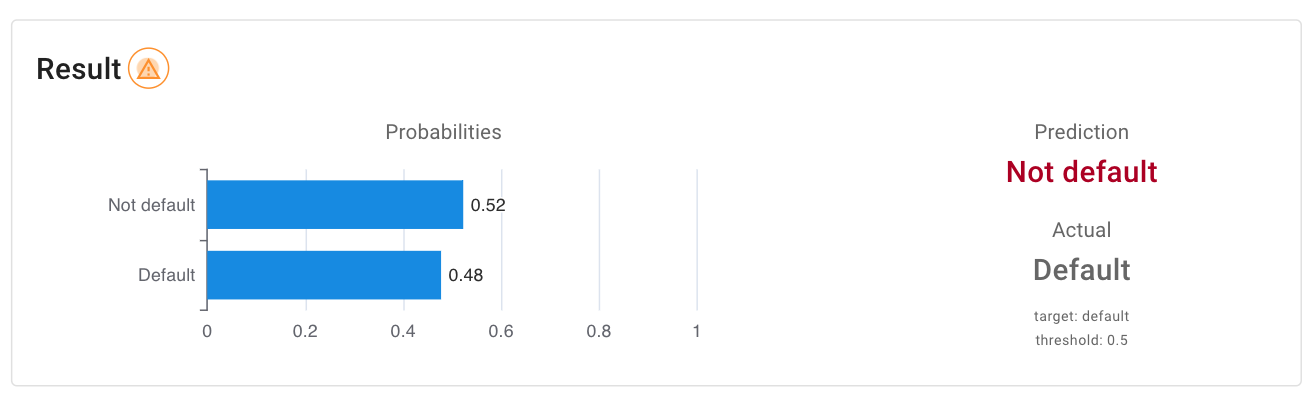

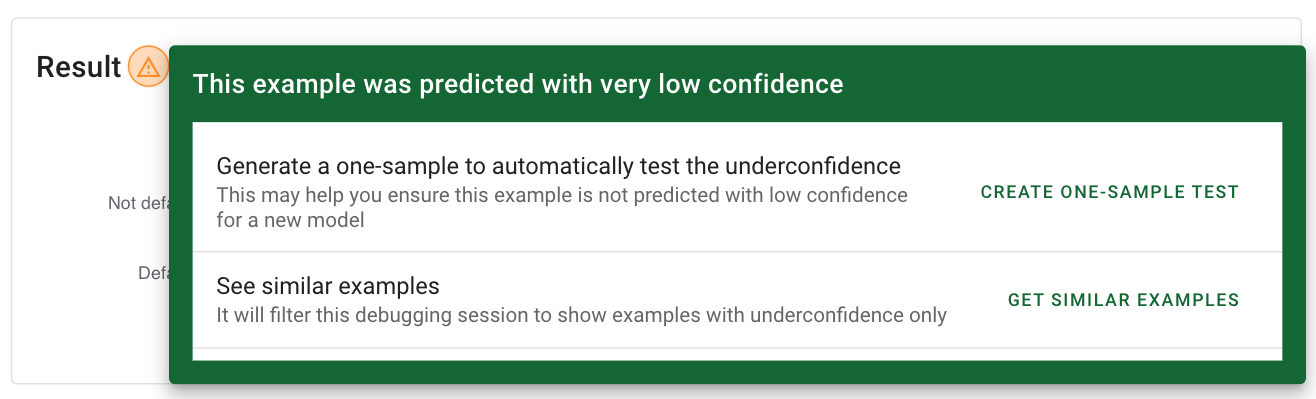

### Upload your test suite to the Giskard Hub

The entry point to the Giskard Hub is the upload of your test suite. Uploading the test suite will automatically save the model, dataset, tests, slicing & transformation functions to the Giskard Hub.

In [ ]:
# Create a Giskard client after having install the Giskard server (see documentation)
api_key = "<Giskard API key>"  #This can be found in the Settings tab of the Giskard hub
#hf_token = "<Your Giskard Space token>" #If the Giskard Hub is installed on HF Space, this can be found on the Settings tab of the Giskard Hub

client = GiskardClient(
    url="http://localhost:19000",  # Option 1: Use URL of your local Giskard instance.
    # url="<URL of your Giskard hub Space>",  # Option 2: Use URL of your remote HuggingFace space.
    key=api_key,
    # hf_token=hf_token  # Use this token to access a private HF space.
)

project_key = "my_project"
my_project = client.create_project(project_key, "PROJECT_NAME", "DESCRIPTION")

# Upload to the project you just created
test_suite.upload(client, project_key)

### Download a test suite from the Giskard Hub

After curating your test suites with additional tests on the Giskard Hub, you can easily download them back into your environment. This allows you to:
  
- Check for regressions after training a new model
- Automate the test suite execution in a CI/CD pipeline
- Compare several models during the prototyping phase

In [ ]:
test_suite_downloaded = Suite.download(client, project_key, suite_id=...)
test_suite_downloaded.run()